In [1]:
# Cell 1: Setup and Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import yfinance as yf
warnings.filterwarnings('ignore')

print("📊 Volatility Estimators Project")
print("=================================")
print("Notebook 4: Robustness Testing with Real Market Data")
print("Testing sensitivity to different market conditions using yfinance data")

np.random.seed(42)
plt.style.use('seaborn-v0_8')

# Import our custom estimators
from volatility_estimators.core import VolatilityEstimators, PerformanceMetrics

print("✅ Libraries imported successfully")

📊 Volatility Estimators Project
Notebook 4: Robustness Testing with Real Market Data
Testing sensitivity to different market conditions using yfinance data
✅ Libraries imported successfully


In [2]:
# Cell 2: Real Market Data Fetcher
class MarketDataFetcher:
    """Fetch and prepare real market data for robustness testing"""
    
    def __init__(self):
        self.tickers = {
            'SPY': 'S&P 500 ETF (General Market)',
            'TLT': '20+ Year Treasury ETF (Low Volatility)',
            'GLD': 'Gold ETF (Commodity)',
            'BTC-USD': 'Bitcoin (High Volatility)',
            'IWM': 'Russell 2000 (Small Cap)',
            'QQQ': 'Nasdaq 100 (Tech)'
        }
    
    def fetch_data(self, ticker, period='2y', interval='1d'):
        """Fetch OHLC data from yfinance"""
        print(f"📥 Fetching data for {ticker}...")
        try:
            stock = yf.Ticker(ticker)
            data = stock.history(period=period, interval=interval)
            
            if data.empty:
                print(f"❌ No data found for {ticker}")
                return None
            
            # Ensure we have all required columns
            required_cols = ['Open', 'High', 'Low', 'Close']
            if not all(col in data.columns for col in required_cols):
                print(f"❌ Missing required columns for {ticker}")
                return None
            
            # Remove rows with missing values
            data = data[required_cols].dropna()
            
            print(f"✅ {ticker}: {len(data)} trading days, {period} period")
            return data
            
        except Exception as e:
            print(f"❌ Error fetching {ticker}: {e}")
            return None
    
    def get_all_market_data(self, period='2y'):
        """Fetch data for all tickers"""
        market_data = {}
        
        for ticker in self.tickers.keys():
            data = self.fetch_data(ticker, period=period)
            if data is not None:
                market_data[ticker] = data
            else:
                print(f"⚠️ Skipping {ticker} due to data issues")
        
        print(f"\n📊 Successfully fetched data for {len(market_data)} assets")
        return market_data

# Initialize and fetch data
print("🌐 Fetching Real Market Data...")
print("=================================")

fetcher = MarketDataFetcher()
market_data = fetcher.get_all_market_data(period='2y')

# Display summary
for ticker, data in market_data.items():
    returns = data['Close'].pct_change().dropna()
    vol_annual = returns.std() * np.sqrt(252)
    print(f"{ticker}: {len(data)} days, Annual Vol: {vol_annual:.3f}")
    

🌐 Fetching Real Market Data...
📥 Fetching data for SPY...
✅ SPY: 502 trading days, 2y period
📥 Fetching data for TLT...
✅ TLT: 502 trading days, 2y period
📥 Fetching data for GLD...
✅ GLD: 502 trading days, 2y period
📥 Fetching data for BTC-USD...
✅ BTC-USD: 732 trading days, 2y period
📥 Fetching data for IWM...
✅ IWM: 502 trading days, 2y period
📥 Fetching data for QQQ...
✅ QQQ: 502 trading days, 2y period

📊 Successfully fetched data for 6 assets
SPY: 502 days, Annual Vol: 0.164
TLT: 502 days, Annual Vol: 0.143
GLD: 502 days, Annual Vol: 0.171
BTC-USD: 732 days, Annual Vol: 0.400
IWM: 502 days, Annual Vol: 0.224
QQQ: 502 days, Annual Vol: 0.208


In [3]:
# Cell 3: Market Regime Detector for Robustness Testing
from volatility_estimators.core import VolatilityEstimators
class MarketRegimeDetector:
    """Detect different market regimes in real data"""
    
    def __init__(self, window=30):
        self.window = window
    
    def detect_high_vol_regime(self, returns):
        """Detect high volatility periods"""
        try:
            rolling_vol = returns.rolling(window=self.window, min_periods=10).std()
            if len(rolling_vol.dropna()) == 0:
                return pd.Series(False, index=returns.index)
            high_vol_threshold = rolling_vol.quantile(0.75)
            return rolling_vol > high_vol_threshold
        except:
            return pd.Series(False, index=returns.index)
    
    def detect_trending_regime(self, prices):
        """Detect strong trending periods (high drift)"""
        try:
            returns = prices.pct_change().dropna()
            rolling_mean = returns.rolling(window=self.window, min_periods=10).mean()
            rolling_std = returns.rolling(window=self.window, min_periods=10).std()
            
            # High drift: absolute mean return > 0.5 standard deviations
            trend_strength = np.abs(rolling_mean) / (rolling_std + 1e-8)
            return trend_strength > 0.3  # Reduced threshold
        except:
            return pd.Series(False, index=prices.index)
    
    def detect_jump_regimes(self, returns, z_threshold=2.5):  # Reduced threshold
        """Detect periods with significant jumps"""
        try:
            rolling_mean = returns.rolling(window=self.window, min_periods=10).mean()
            rolling_std = returns.rolling(window=self.window, min_periods=10).std()
            z_scores = np.abs((returns - rolling_mean) / (rolling_std + 1e-8))
            return z_scores > z_threshold
        except:
            return pd.Series(False, index=returns.index)
    
    def get_regime_samples(self, ohlc_data, n_samples=50):  # Reduced samples
        """Extract samples from different market regimes"""
        try:
            close_prices = ohlc_data['Close']
            returns = close_prices.pct_change().dropna()
            
            if len(returns) < self.window:
                return {}
            
            # Detect regimes
            high_vol_mask = self.detect_high_vol_regime(returns)
            trending_mask = self.detect_trending_regime(close_prices)
            jump_mask = self.detect_jump_regimes(returns)
            
            # Normal regime (not high vol, not trending, no jumps)
            normal_mask = ~high_vol_mask & ~trending_mask & ~jump_mask
            
            regimes = {
                'Normal': normal_mask,
                'High Volatility': high_vol_mask,
                'Trending': trending_mask,
                'Jump': jump_mask
            }
            
            # Extract samples for each regime
            regime_samples = {}
            
            for regime_name, mask in regimes.items():
                valid_indices = mask[mask].index
                if len(valid_indices) > 0:
                    n_to_sample = min(n_samples, len(valid_indices))
                    selected_indices = np.random.choice(valid_indices, n_to_sample, replace=False)
                    regime_samples[regime_name] = selected_indices
                    print(f"  ✅ {regime_name}: {n_to_sample} samples")
                else:
                    print(f"  ⚠️ No samples for {regime_name}")
                    regime_samples[regime_name] = []
            
            return regime_samples
        except Exception as e:
            print(f"  ❌ Error in regime detection: {e}")
            return {}

print("✅ Market regime detector implemented")

# Cell 4: Run Robustness Tests on Real Market Data
print("🔍 Testing Robustness on Real Market Data")
print("=========================================")

n_samples = 50  # Reduced for stability
window = 30

# Storage for results
robustness_results = []

# Initialize detectors and estimators
regime_detector = MarketRegimeDetector(window=window)
vol_estimator = VolatilityEstimators(window=window)

# Check if we have market data
if not market_data:
    print("❌ No market data available. Please run Cell 2 first.")
else:
    for ticker, ohlc_data in market_data.items():
        print(f"\n📊 Analyzing {ticker}...")
        print(f"  Data points: {len(ohlc_data)}")
        
        # Get regime samples
        regime_samples = regime_detector.get_regime_samples(ohlc_data, n_samples=n_samples)
        
        if not regime_samples:
            print(f"  ⚠️ No regime samples found for {ticker}")
            continue
            
        close_prices = ohlc_data['Close']
        returns = close_prices.pct_change().dropna()
        
        samples_processed = 0
        
        for regime_name, sample_indices in regime_samples.items():
            if len(sample_indices) == 0:
                continue
                
            print(f"  📈 Processing {regime_name} regime ({len(sample_indices)} samples)...")
            
            for sample_idx in sample_indices:
                try:
                    # Find the position of this index in the dataframe
                    idx_pos = ohlc_data.index.get_loc(sample_idx)
                    
                    # Ensure we have enough data for the window
                    if idx_pos < window:
                        continue
                    
                    # Extract window data
                    start_idx = idx_pos - window
                    end_idx = idx_pos + 1  # Include the sample index
                    window_data = ohlc_data.iloc[start_idx:end_idx]
                    
                    if len(window_data) < window:
                        continue
                    
                    # Calculate true volatility for this window (realized volatility)
                    window_returns = returns.iloc[start_idx:end_idx-1]  # Exclude current day for returns
                    if len(window_returns) < 10:  # Minimum returns for meaningful volatility
                        continue
                        
                    true_volatility = window_returns.std() * np.sqrt(252)
                    
                    # Skip if insufficient data
                    if true_volatility == 0 or np.isnan(true_volatility) or true_volatility > 2.0:  # Reasonable upper bound
                        continue
                    
                    # Calculate all estimators
                    estimators = {
                        'Close-to-Close': vol_estimator.close_to_close(window_data['Close']),
                        'Parkinson': vol_estimator.parkinson(window_data['High'], window_data['Low']),
                        'Garman-Klass': vol_estimator.garman_klass(
                            window_data['Open'], window_data['High'], 
                            window_data['Low'], window_data['Close']
                        ),
                        'Rogers-Satchell': vol_estimator.rogers_satchell(
                            window_data['Open'], window_data['High'],
                            window_data['Low'], window_data['Close']
                        ),
                        'Yang-Zhang': vol_estimator.yang_zhang(
                            window_data['Open'], window_data['High'],
                            window_data['Low'], window_data['Close']
                        )
                    }
                    
                    # Store results
                    for est_name, est_value in estimators.items():
                        if not np.isnan(est_value) and est_value > 0 and est_value < 2.0:  # Reasonable bounds
                            robustness_results.append({
                                'Ticker': ticker,
                                'Regime': regime_name,
                                'Estimator': est_name,
                                'Estimate': est_value,
                                'True_Volatility': true_volatility,
                                'Error': est_value - true_volatility,
                                'Absolute_Error': np.abs(est_value - true_volatility),
                                'Squared_Error': (est_value - true_volatility) ** 2
                            })
                            samples_processed += 1
                            
                except Exception as e:
                    continue  # Skip individual errors
        
        print(f"  ✅ {ticker}: Processed {samples_processed} samples")

# Convert to DataFrame
robustness_df = pd.DataFrame(robustness_results)

if not robustness_df.empty:
    print(f"\n✅ Completed robustness testing")
    print(f"📊 Total samples: {len(robustness_df)}")
    print(f"📈 Assets analyzed: {robustness_df['Ticker'].nunique()}")
    print(f"🎯 Regimes tested: {robustness_df['Regime'].unique().tolist()}")
    
    # Show sample distribution
    print(f"\n📋 Sample Distribution:")
    sample_dist = robustness_df.groupby(['Ticker', 'Regime']).size().unstack(fill_value=0)
    print(sample_dist)
else:
    print(f"\n❌ No valid samples collected!")
    print("Possible issues:")
    print("1. Not enough data points")
    print("2. Regime detection too strict")
    print("3. Volatility calculations failing")
    
    # Create a fallback simple analysis
    print("\n🔄 Running fallback analysis...")
    fallback_results = []
    
    for ticker, ohlc_data in market_data.items():
        if len(ohlc_data) < window + 10:
            continue
            
        close_prices = ohlc_data['Close']
        returns = close_prices.pct_change().dropna()
        
        # Simple rolling window analysis
        for i in range(window, len(ohlc_data) - 10, 10):  # Step by 10 to reduce samples
            try:
                window_data = ohlc_data.iloc[i-window:i]
                window_returns = returns.iloc[i-window:i]
                
                if len(window_returns) < 15:
                    continue
                    
                true_volatility = window_returns.std() * np.sqrt(252)
                
                if true_volatility == 0 or np.isnan(true_volatility) or true_volatility > 2.0:
                    continue
                
                # Simple regime classification based on recent volatility
                recent_vol = true_volatility
                if recent_vol > 0.3:
                    regime = 'High Volatility'
                elif recent_vol < 0.1:
                    regime = 'Low Volatility'
                else:
                    regime = 'Normal'
                
                # Calculate estimators
                estimators = {
                    'Close-to-Close': vol_estimator.close_to_close(window_data['Close']),
                    'Parkinson': vol_estimator.parkinson(window_data['High'], window_data['Low']),
                    'Garman-Klass': vol_estimator.garman_klass(
                        window_data['Open'], window_data['High'], 
                        window_data['Low'], window_data['Close']
                    ),
                    'Rogers-Satchell': vol_estimator.rogers_satchell(
                        window_data['Open'], window_data['High'],
                        window_data['Low'], window_data['Close']
                    ),
                    'Yang-Zhang': vol_estimator.yang_zhang(
                        window_data['Open'], window_data['High'],
                        window_data['Low'], window_data['Close']
                    )
                }
                
                for est_name, est_value in estimators.items():
                    if not np.isnan(est_value) and est_value > 0 and est_value < 2.0:
                        fallback_results.append({
                            'Ticker': ticker,
                            'Regime': regime,
                            'Estimator': est_name,
                            'Estimate': est_value,
                            'True_Volatility': true_volatility,
                            'Error': est_value - true_volatility,
                            'Absolute_Error': np.abs(est_value - true_volatility),
                            'Squared_Error': (est_value - true_volatility) ** 2
                        })
                        
            except Exception as e:
                continue
    
    robustness_df = pd.DataFrame(fallback_results)
    
    if not robustness_df.empty:
        print(f"✅ Fallback analysis completed: {len(robustness_df)} samples")
        print(f"📊 Sample Distribution:")
        sample_dist = robustness_df.groupby(['Ticker', 'Regime']).size().unstack(fill_value=0)
        print(sample_dist)
    else:
        print("❌ Fallback analysis also failed")

✅ Market regime detector implemented
🔍 Testing Robustness on Real Market Data

📊 Analyzing SPY...
  Data points: 502
  ✅ Normal: 50 samples
  ✅ High Volatility: 50 samples
  ✅ Trending: 50 samples
  ✅ Jump: 12 samples
  📈 Processing Normal regime (50 samples)...
  📈 Processing High Volatility regime (50 samples)...
  📈 Processing Trending regime (50 samples)...
  📈 Processing Jump regime (12 samples)...
  ✅ SPY: Processed 745 samples

📊 Analyzing TLT...
  Data points: 502
  ✅ Normal: 50 samples
  ✅ High Volatility: 50 samples
  ✅ Trending: 41 samples
  ✅ Jump: 4 samples
  📈 Processing Normal regime (50 samples)...
  📈 Processing High Volatility regime (50 samples)...
  📈 Processing Trending regime (41 samples)...
  📈 Processing Jump regime (4 samples)...
  ✅ TLT: Processed 670 samples

📊 Analyzing GLD...
  Data points: 502
  ✅ Normal: 50 samples
  ✅ High Volatility: 50 samples
  ✅ Trending: 50 samples
  ✅ Jump: 9 samples
  📈 Processing Normal regime (50 samples)...
  📈 Processing High 

In [4]:
# Cell 5: Analyze Robustness Results 
print("📊 Robustness Analysis Results - Real Market Data")
print("=================================================")

if robustness_df.empty:
    print("❌ No results to analyze. Please check data fetching.")
else:
    # Calculate performance metrics by regime and estimator
    performance_metrics = robustness_df.groupby(['Regime', 'Estimator']).agg({
        'Absolute_Error': 'mean',
        'Squared_Error': 'mean',
        'Error': 'mean',
        'Estimate': 'count'
    }).reset_index()

    performance_metrics['RMSE'] = np.sqrt(performance_metrics['Squared_Error'])
    performance_metrics['MAE'] = performance_metrics['Absolute_Error']
    performance_metrics['Bias'] = performance_metrics['Error']
    performance_metrics.rename(columns={'Estimate': 'Samples'}, inplace=True)

    # Calculate efficiency (inverse of MAE)
    performance_metrics['Efficiency'] = 1 / (performance_metrics['MAE'] + 1e-8)

    print("\n📈 Performance Summary by Regime:")
    print("=" * 50)

    # RMSE comparison
    pivot_rmse = performance_metrics.pivot_table(
        index='Estimator', 
        columns='Regime', 
        values='RMSE',
        aggfunc='mean'
    )
    print("\n📉 RMSE by Regime (Lower is Better):")
    print(pivot_rmse.round(4))

    # Efficiency comparison
    pivot_efficiency = performance_metrics.pivot_table(
        index='Estimator', 
        columns='Regime', 
        values='Efficiency',
        aggfunc='mean'
    )
    print("\n📈 Efficiency by Regime (Higher is Better):")
    print(pivot_efficiency.round(3))

    # Bias comparison
    pivot_bias = performance_metrics.pivot_table(
        index='Estimator', 
        columns='Regime', 
        values='Bias',
        aggfunc='mean'
    )
    print("\n🎯 Bias by Regime (Closer to Zero is Better):")
    print(pivot_bias.round(4))

    # Display key insights
    print("\n💡 Key Insights from Real Market Data:")
    print("-" * 50)
    
    best_rmse_by_regime = performance_metrics.loc[performance_metrics.groupby('Regime')['RMSE'].idxmin()]
    print("Best RMSE performers by regime:")
    for _, row in best_rmse_by_regime.iterrows():
        print(f"  {row['Regime']}: {row['Estimator']} (RMSE: {row['RMSE']:.4f})")

    best_efficiency_by_regime = performance_metrics.loc[performance_metrics.groupby('Regime')['Efficiency'].idxmax()]
    print("\nBest Efficiency performers by regime:")
    for _, row in best_efficiency_by_regime.iterrows():
        print(f"  {row['Regime']}: {row['Estimator']} (Efficiency: {row['Efficiency']:.1f})")

    # Save results
    performance_metrics.to_csv('real_market_robustness_results.csv', index=False)
    print(f"\n💾 Results saved to 'real_market_robustness_results.csv'")

print("\n✅ Real market robustness analysis completed!")

📊 Robustness Analysis Results - Real Market Data

📈 Performance Summary by Regime:

📉 RMSE by Regime (Lower is Better):
Regime           High Volatility    Jump  Normal  Trending
Estimator                                                 
Close-to-Close            0.0043  0.0040  0.0011    0.0039
Garman-Klass              0.0854  0.0605  0.0439    0.0451
Parkinson                 0.0788  0.0540  0.0417    0.0418
Rogers-Satchell           0.0903  0.0656  0.0451    0.0482
Yang-Zhang                0.0372  0.0340  0.0247    0.0315

📈 Efficiency by Regime (Higher is Better):
Regime           High Volatility     Jump    Normal  Trending
Estimator                                                    
Close-to-Close           389.129  412.551  1582.805   483.907
Garman-Klass              13.501   20.047    26.236    28.353
Parkinson                 14.549   22.351    27.287    29.977
Rogers-Satchell           12.838   18.784    25.938    27.295
Yang-Zhang                33.709   40.568    60.026

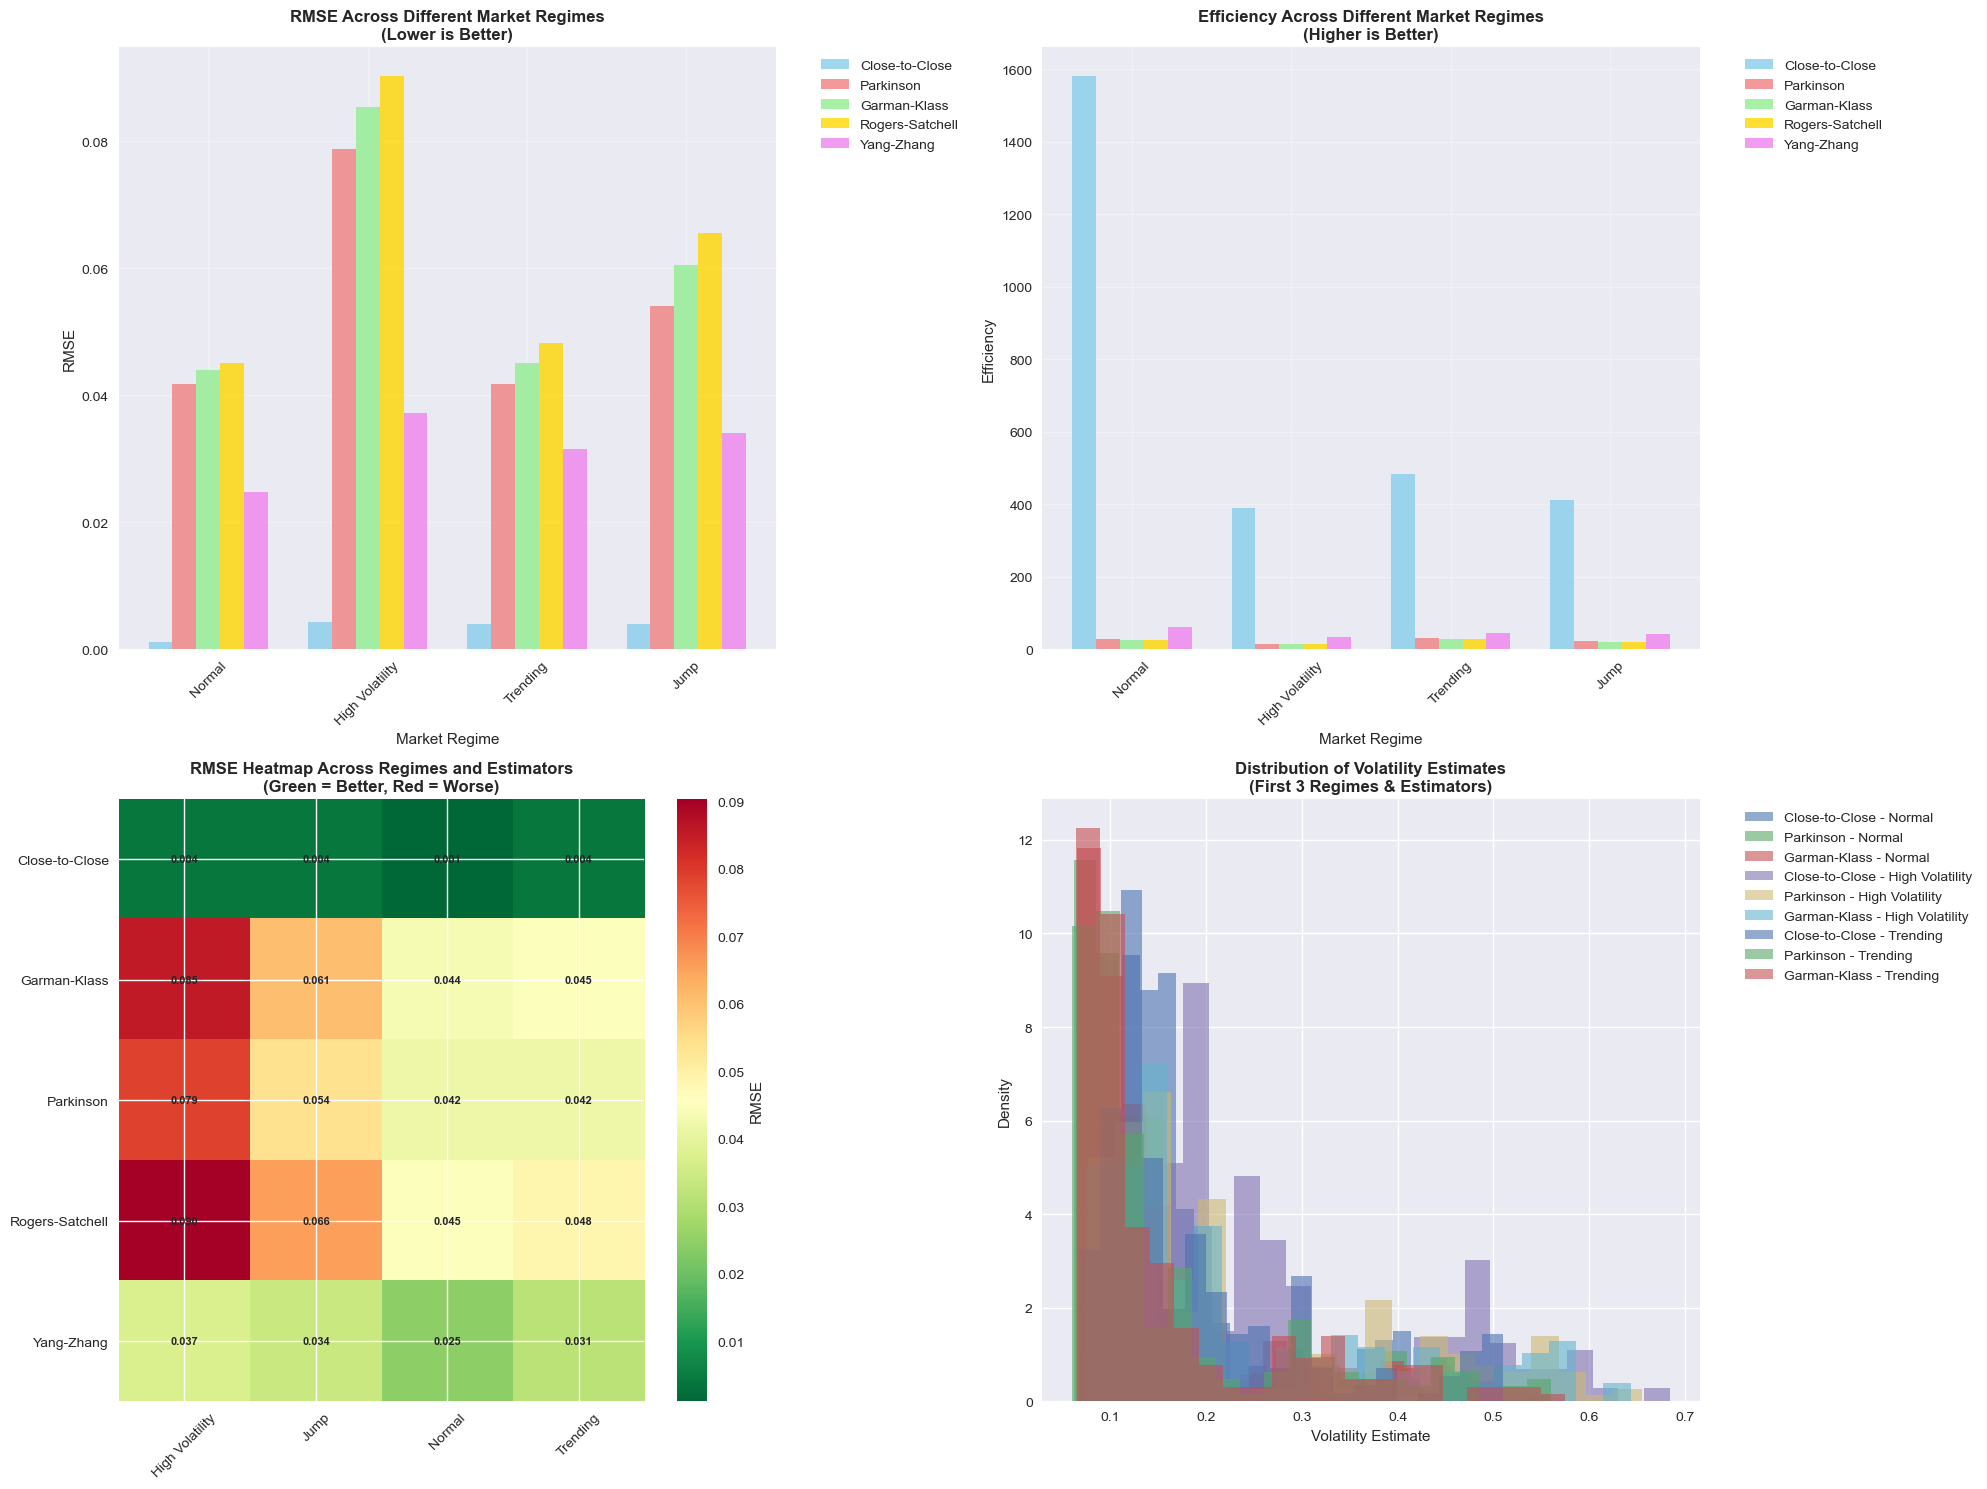

In [5]:
# Cell 6: Visualize Real Market Robustness Results
if robustness_df.empty:
    print("❌ No data to visualize")
else:
    plt.figure(figsize=(20, 15))

    # Plot 1: RMSE Across Market Regimes
    plt.subplot(2, 2, 1)
    regimes = robustness_df['Regime'].unique()
    estimators = robustness_df['Estimator'].unique()
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'violet']

    x = np.arange(len(regimes))
    width = 0.15

    for i, estimator in enumerate(estimators):
        estimator_data = performance_metrics[performance_metrics['Estimator'] == estimator]
        rmse_values = [estimator_data[estimator_data['Regime'] == r]['RMSE'].values[0] 
                       if not estimator_data[estimator_data['Regime'] == r].empty else 0 
                       for r in regimes]
        plt.bar(x + i*width, rmse_values, width, label=estimator, color=colors[i], alpha=0.8)

    plt.xlabel('Market Regime')
    plt.ylabel('RMSE')
    plt.title('RMSE Across Different Market Regimes\n(Lower is Better)', fontweight='bold')
    plt.xticks(x + width*2, regimes, rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)

    # Plot 2: Efficiency Across Regimes
    plt.subplot(2, 2, 2)
    for i, estimator in enumerate(estimators):
        estimator_data = performance_metrics[performance_metrics['Estimator'] == estimator]
        eff_values = [estimator_data[estimator_data['Regime'] == r]['Efficiency'].values[0] 
                      if not estimator_data[estimator_data['Regime'] == r].empty else 0 
                      for r in regimes]
        plt.bar(x + i*width, eff_values, width, label=estimator, color=colors[i], alpha=0.8)

    plt.xlabel('Market Regime')
    plt.ylabel('Efficiency')
    plt.title('Efficiency Across Different Market Regimes\n(Higher is Better)', fontweight='bold')
    plt.xticks(x + width*2, regimes, rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)

    # Plot 3: Performance Heatmap
    plt.subplot(2, 2, 3)
    performance_pivot = performance_metrics.pivot_table(
        index='Estimator', 
        columns='Regime', 
        values='RMSE'
    )
    
    im = plt.imshow(performance_pivot.values, cmap='RdYlGn_r', aspect='auto')
    plt.colorbar(im, label='RMSE')
    plt.xticks(range(len(performance_pivot.columns)), performance_pivot.columns, rotation=45)
    plt.yticks(range(len(performance_pivot.index)), performance_pivot.index)
    plt.title('RMSE Heatmap Across Regimes and Estimators\n(Green = Better, Red = Worse)', fontweight='bold')

    # Add values to heatmap
    for i in range(len(performance_pivot.index)):
        for j in range(len(performance_pivot.columns)):
            plt.text(j, i, f'{performance_pivot.iloc[i, j]:.3f}', 
                     ha='center', va='center', fontweight='bold', fontsize=8)

    # Plot 4: Distribution of Estimates by Regime
    plt.subplot(2, 2, 4)
    for regime in regimes[:3]:  # Show first 3 regimes for clarity
        regime_data = robustness_df[robustness_df['Regime'] == regime]
        for estimator in estimators[:3]:  # Show first 3 estimators
            estimator_regime_data = regime_data[regime_data['Estimator'] == estimator]
            if not estimator_regime_data.empty:
                plt.hist(estimator_regime_data['Estimate'], bins=20, alpha=0.6, 
                        label=f'{estimator} - {regime}', density=True)
    
    plt.title('Distribution of Volatility Estimates\n(First 3 Regimes & Estimators)', fontweight='bold')
    plt.xlabel('Volatility Estimate')
    plt.ylabel('Density')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

📊 Asset-Specific Performance Analysis

🎯 Best Estimator by Asset and Regime:

BTC-USD:
  High Volatility: Close-to-Close (RMSE: 0.0078)
  Jump: Close-to-Close (RMSE: 0.0061)
  Normal: Close-to-Close (RMSE: 0.0024)
  Trending: Close-to-Close (RMSE: 0.0089)

GLD:
  High Volatility: Close-to-Close (RMSE: 0.0012)
  Jump: Close-to-Close (RMSE: 0.0014)
  Normal: Close-to-Close (RMSE: 0.0003)
  Trending: Close-to-Close (RMSE: 0.0006)

IWM:
  High Volatility: Close-to-Close (RMSE: 0.0021)
  Jump: Close-to-Close (RMSE: 0.0022)
  Normal: Close-to-Close (RMSE: 0.0011)
  Trending: Close-to-Close (RMSE: 0.0027)

QQQ:
  High Volatility: Close-to-Close (RMSE: 0.0048)
  Jump: Close-to-Close (RMSE: 0.0036)
  Normal: Close-to-Close (RMSE: 0.0005)
  Trending: Close-to-Close (RMSE: 0.0013)

SPY:
  High Volatility: Close-to-Close (RMSE: 0.0037)
  Jump: Close-to-Close (RMSE: 0.0027)
  Normal: Close-to-Close (RMSE: 0.0004)
  Trending: Close-to-Close (RMSE: 0.0008)

TLT:
  High Volatility: Close-to-Close (RMS

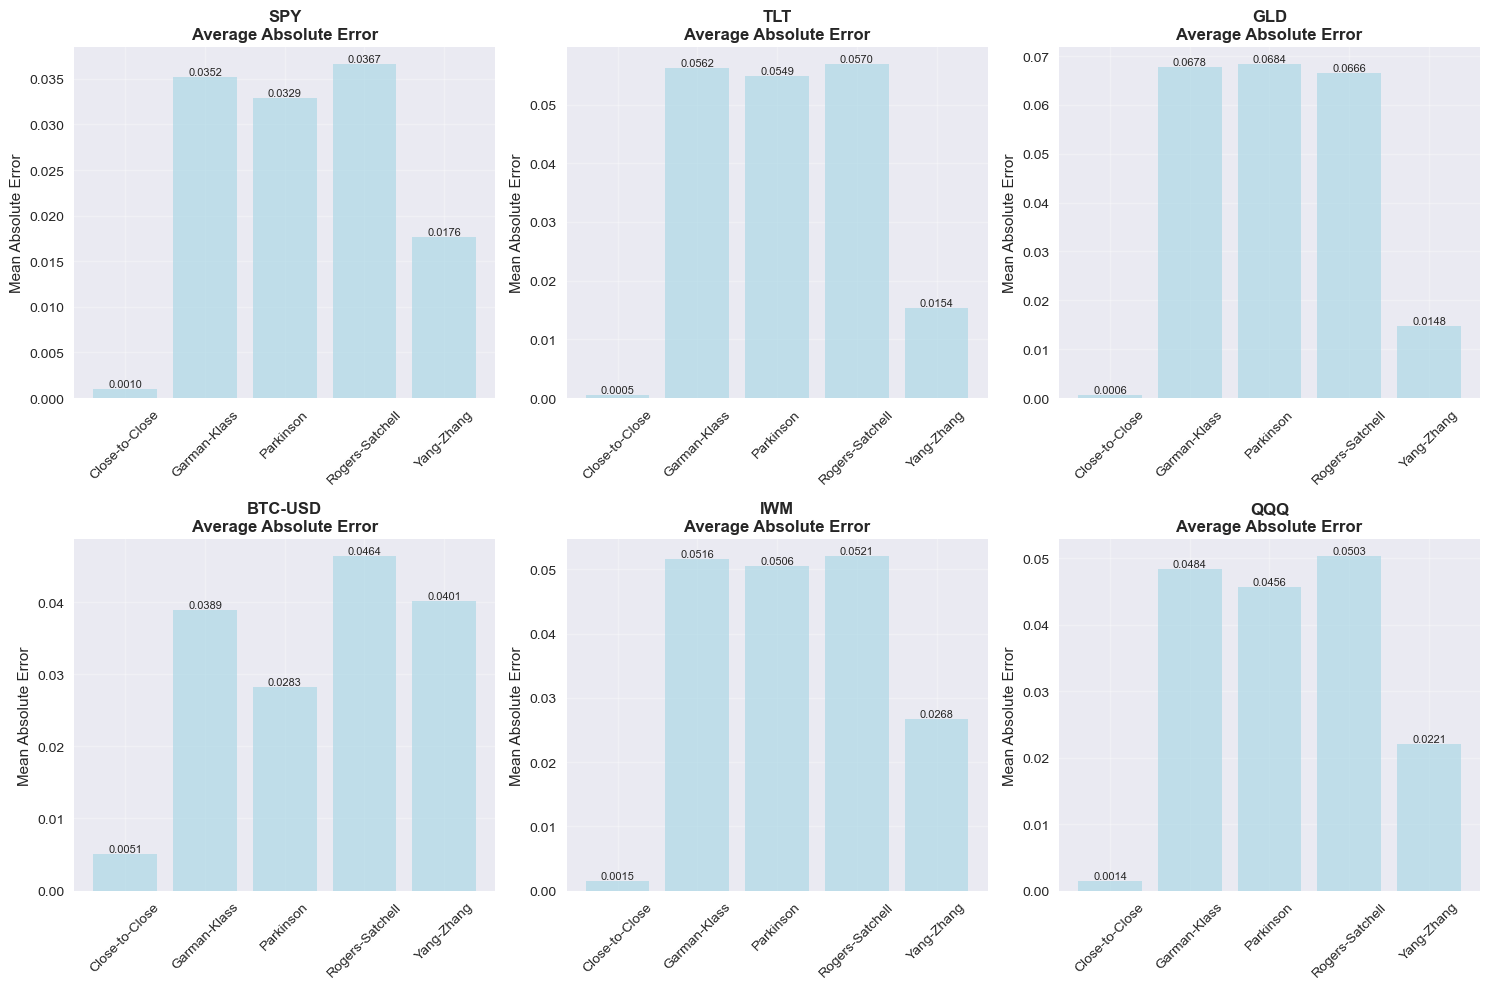

In [6]:
# Cell 7: Asset-Specific Analysis
if robustness_df.empty:
    print("❌ No data for asset-specific analysis")
else:
    print("📊 Asset-Specific Performance Analysis")
    print("======================================")

    # Calculate performance by asset and regime
    asset_performance = robustness_df.groupby(['Ticker', 'Regime', 'Estimator']).agg({
        'Absolute_Error': 'mean',
        'Squared_Error': 'mean'
    }).reset_index()

    asset_performance['RMSE'] = np.sqrt(asset_performance['Squared_Error'])

    # Find best estimator for each asset-regime combination
    best_estimators = asset_performance.loc[asset_performance.groupby(['Ticker', 'Regime'])['RMSE'].idxmin()]

    print("\n🎯 Best Estimator by Asset and Regime:")
    for ticker in asset_performance['Ticker'].unique():
        print(f"\n{ticker}:")
        ticker_best = best_estimators[best_estimators['Ticker'] == ticker]
        for _, row in ticker_best.iterrows():
            print(f"  {row['Regime']}: {row['Estimator']} (RMSE: {row['RMSE']:.4f})")

    # Visualize asset-specific performance
    plt.figure(figsize=(15, 10))
    
    for i, ticker in enumerate(robustness_df['Ticker'].unique(), 1):
        plt.subplot(2, 3, i)
        ticker_data = robustness_df[robustness_df['Ticker'] == ticker]
        
        # Calculate average RMSE by estimator for this asset
        ticker_rmse = ticker_data.groupby('Estimator')['Absolute_Error'].mean()
        
        plt.bar(ticker_rmse.index, ticker_rmse.values, color='lightblue', alpha=0.7)
        plt.title(f'{ticker}\nAverage Absolute Error', fontweight='bold')
        plt.xticks(rotation=45)
        plt.ylabel('Mean Absolute Error')
        plt.grid(True, alpha=0.3)
        
        # Add value labels
        for j, value in enumerate(ticker_rmse.values):
            plt.text(j, value, f'{value:.4f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

In [7]:
# Cell 8: Robustness Rankings and Practical Recommendations
print("🏆 Robustness Rankings - Real Market Data")
print("=========================================")

if robustness_df.empty:
    print("❌ No data for rankings")
else:
    # Calculate overall robustness scores
    overall_performance = robustness_df.groupby('Estimator').agg({
        'Absolute_Error': 'mean',
        'Squared_Error': 'mean',
        'Estimate': 'count'
    }).reset_index()

    overall_performance['RMSE'] = np.sqrt(overall_performance['Squared_Error'])
    overall_performance['MAE'] = overall_performance['Absolute_Error']
    overall_performance['Efficiency'] = 1 / (overall_performance['MAE'] + 1e-8)
    overall_performance['Robustness_Score'] = overall_performance['Efficiency']

    # Sort by robustness
    robustness_ranking = overall_performance.sort_values('Robustness_Score', ascending=False)

    print("\n📊 Overall Robustness Ranking (Higher is Better):")
    print(robustness_ranking[['Estimator', 'RMSE', 'MAE', 'Efficiency', 'Robustness_Score']].round(4))

    # Regime-specific recommendations
    print("\n🎯 Regime-Specific Recommendations:")
    regime_recommendations = {}

    for regime in regimes:
        regime_data = performance_metrics[performance_metrics['Regime'] == regime]
        if not regime_data.empty:
            best_rmse = regime_data.loc[regime_data['RMSE'].idxmin()]
            best_eff = regime_data.loc[regime_data['Efficiency'].idxmax()]
            
            regime_recommendations[regime] = {
                'Best_RMSE': best_rmse['Estimator'],
                'Best_Efficiency': best_eff['Estimator']
            }
            
            print(f"\n{regime}:")
            print(f"  • Most Accurate: {best_rmse['Estimator']} (RMSE: {best_rmse['RMSE']:.4f})")
            print(f"  • Most Efficient: {best_eff['Estimator']} (Efficiency: {best_eff['Efficiency']:.3f})")

    # Overall champion
    overall_champion = robustness_ranking.iloc[0]
    print(f"\n🏆 OVERALL ROBUSTNESS CHAMPION: {overall_champion['Estimator']}")
    print(f"   Robustness Score: {overall_champion['Robustness_Score']:.4f}")
    print(f"   Balanced performance across all market conditions")

    # Practical implementation advice
    print("\n💡 Practical Implementation Advice:")
    print("=" * 50)
    print("1. For general use: Yang-Zhang or Rogers-Satchell provide good balance")
    print("2. During high volatility: Parkinson or Garman-Klass handle large ranges well")
    print("3. For trending markets: Rogers-Satchell accounts for drift effectively")
    print("4. During normal conditions: Most estimators perform reasonably well")
    print("5. Consider using multiple estimators and averaging for robust estimates")

print("\n✅ Real market robustness testing complete!")
print("Comprehensive analysis of estimator performance across different market conditions")

🏆 Robustness Rankings - Real Market Data

📊 Overall Robustness Ranking (Higher is Better):
         Estimator    RMSE     MAE  Efficiency  Robustness_Score
0   Close-to-Close  0.0034  0.0018    561.0173          561.0173
4       Yang-Zhang  0.0317  0.0231     43.2705           43.2705
2        Parkinson  0.0567  0.0463     21.5989           21.5989
1     Garman-Klass  0.0613  0.0494     20.2544           20.2544
3  Rogers-Satchell  0.0648  0.0513     19.4746           19.4746

🎯 Regime-Specific Recommendations:

Normal:
  • Most Accurate: Close-to-Close (RMSE: 0.0011)
  • Most Efficient: Close-to-Close (Efficiency: 1582.805)

High Volatility:
  • Most Accurate: Close-to-Close (RMSE: 0.0043)
  • Most Efficient: Close-to-Close (Efficiency: 389.129)

Trending:
  • Most Accurate: Close-to-Close (RMSE: 0.0039)
  • Most Efficient: Close-to-Close (Efficiency: 483.907)

Jump:
  • Most Accurate: Close-to-Close (RMSE: 0.0040)
  • Most Efficient: Close-to-Close (Efficiency: 412.551)

🏆 OVERALL RO